In [3]:
!pip install qiskit qiskit-aer matplotlib numpy pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 115.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.3 MB/s eta 0:00:00


In [4]:
import os, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import state_fidelity, Statevector
from qiskit_aer.noise import NoiseModel, depolarizing_error, amplitude_damping_error, ReadoutError

RNG_SEED = 42
np.random.seed(RNG_SEED)

os.makedirs("results", exist_ok=True)
os.makedirs("notebooks", exist_ok=True)

print("Environment ready. Qiskit version:", __import__('qiskit').__version__)

Environment ready. Qiskit version: 2.2.3


In [5]:
!pip install pylatexenc


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=77eddaea0b5aa065f390fb49341012c31711510784f38a165e6dba02099c4896
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


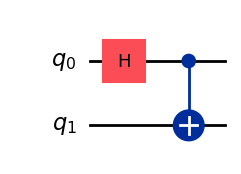

In [6]:
from qiskit import QuantumCircuit
def build_bell_circuit():
    qc=QuantumCircuit(2)
    qc.h(0)
    qc.cx(0,1)
    return qc

qc = build_bell_circuit()
qc.draw('mpl')

In [7]:
from qiskit_aer import Aer
sv_sim = Aer.get_backend('aer_simulator')
qc_sv = qc.copy()
qc_sv.save_statevector()
job = sv_sim.run(qc_sv)
res = job.result()
ideal_state = res.get_statevector()
print("Ideal statevector length:", len(ideal_state))

Ideal statevector length: 4


/tmp/ipython-input-705172023.py:8: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  print("Ideal statevector length:", len(ideal_state))


In [8]:
from qiskit_aer.noise import pauli_error, thermal_relaxation_error, NoiseModel, depolarizing_error, ReadoutError
def noise_model_depolarizing(depol_prob=0.0, readout_error_prob=0.0):
    nm = NoiseModel()
    single_err = depolarizing_error(depol_prob, 1)
    twoq_err = depolarizing_error(depol_prob*2, 2)
    nm.add_all_qubit_quantum_error(single_err, ['u1','u2','u3','id','rz','sx','x','h'])
    nm.add_all_qubit_quantum_error(twoq_err, ['cx','cz','swap'])
    if readout_error_prob > 0:
        readout = ReadoutError([[1-readout_error_prob, readout_error_prob],
                                [readout_error_prob, 1-readout_error_prob]])
        nm.add_all_qubit_readout_error(readout)
    return nm


In [9]:
from qiskit_aer import Aer
from qiskit.quantum_info import state_fidelity
RNG_SEED = 42
def run_statevector_sim(qc, noise_model=None, shots=0, seed_sim=None):
    backend = Aer.get_backend('aer_simulator')
    circ = qc.copy()

    if noise_model is not None:
        circ.save_density_matrix()
        job = backend.run(circ, noise_model=noise_model, shots=shots, method="density_matrix", seed_simulator=seed_sim)
        res = job.result()
        sv_or_dm = res.data(0)['density_matrix']
    else:
        circ.save_statevector()
        job = backend.run(circ, noise_model=noise_model, shots=shots, method="statevector", seed_simulator=seed_sim)
        res = job.result()
        sv_or_dm = res.get_statevector()
    return sv_or_dm


sv_ideal = run_statevector_sim(qc, noise_model=None, seed_sim=RNG_SEED)
print("Ideal fidelity with itself:", state_fidelity(sv_ideal, sv_ideal))

Ideal fidelity with itself: 1.0


In [10]:
import numpy as np
import pandas as pd
from qiskit.quantum_info import state_fidelity
import os

os.makedirs("results", exist_ok=True)

def compute_fidelity_for_params(qc, depol_vals, readout_vals=None, seeds=None):
    if seeds is None:
        seeds = [int(RNG_SEED+i) for i in range(5)]
    if readout_vals is None:
        readout_vals = [0.0]*len(depol_vals)
    rows = []
    for i, p in enumerate(depol_vals):
        r = readout_vals[i] if i < len(readout_vals) else 0.0
        fidelities = []
        for seed in seeds:
            nm = noise_model_depolarizing(depol_prob=p, readout_error_prob=r)
            sv_noisy = run_statevector_sim(qc, noise_model=nm, seed_sim=seed)

            f = state_fidelity(ideal_state, sv_noisy)
            fidelities.append(f)
        rows.append({
            "depol_prob": p,
            "readout_prob": r,
            "fidelity_mean": np.mean(fidelities),
            "fidelity_std": np.std(fidelities),
            "num_seeds": len(seeds)
        })
    return pd.DataFrame(rows)


depol_vals = np.linspace(0.0, 0.05, 8)
seeds = [1001, 1002, 1003, 1004, 1005]

df = compute_fidelity_for_params(qc, depol_vals, seeds=seeds)
df.to_csv("results/exp1_noise_sweep.csv", index=False)
df

,depol_prob,readout_prob,fidelity_mean,fidelity_std,num_seeds
0,0.000000,0.0,1.000000,0.000000e+00,5
1,0.007143,0.0,0.985765,0.000000e+00,5
2,0.014286,0.0,0.971633,1.110223e-16,5
3,0.021429,0.0,0.957602,0.000000e+00,5
4,0.028571,0.0,0.943673,1.110223e-16,5
5,0.035714,0.0,0.929847,0.000000e+00,5
6,0.042857,0.0,0.916122,0.000000e+00,5
7,0.050000,0.0,0.902500,0.000000e+00,5


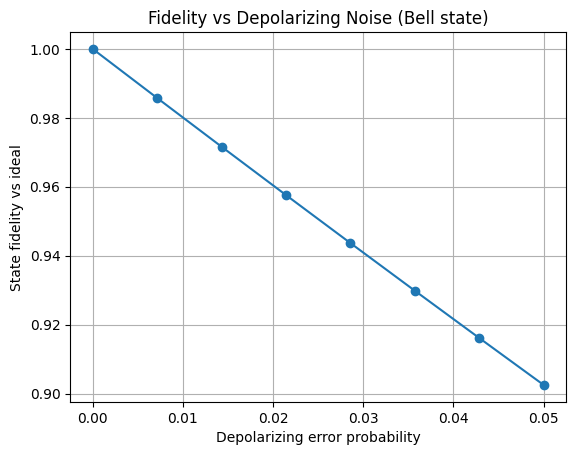

In [11]:
import matplotlib.pyplot as plt
df = pd.read_csv("results/exp1_noise_sweep.csv")
plt.errorbar(df['depol_prob'], df['fidelity_mean'], yerr=df['fidelity_std'], marker='o', linestyle='-')
plt.xlabel("Depolarizing error probability")
plt.ylabel("State fidelity vs ideal")
plt.title("Fidelity vs Depolarizing Noise (Bell state)")
plt.grid(True)
plt.savefig("results/fig_fidelity_vs_noise.png", dpi=300)
plt.show()

In [12]:
detailed = []
for p in depol_vals:
    for seed in seeds:
        nm = noise_model_depolarizing(depol_prob=float(p))
        sv_noisy = run_statevector_sim(qc, noise_model=nm, seed_sim=int(seed))
        f = state_fidelity(ideal_state, sv_noisy)
        detailed.append({"depol_prob": float(p), "seed": int(seed), "fidelity": float(f)})
pd.DataFrame(detailed).to_csv("results/exp1_raw_per_seed.csv", index=False)
print("Saved detailed raw CSV")


Saved detailed raw CSV
